# General BERT Attention Analysis

This notebook contains code for analyzing general patterns BERT's attention (see Sections 3 and 6 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [47]:
!git clone https://github.com/manba036/attention-analysis.git

Cloning into 'attention-analysis'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 77 (delta 29), reused 57 (delta 17), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [48]:
%cd attention-analysis

/content/attention-analysis/attention-analysis/attention-analysis


In [0]:
from google.colab import auth
auth.authenticate_user()

In [51]:
!gsutil cp gs://hisaka/model/model.ckpt-1400000*   ./model/bert-wiki-ja/

Copying gs://hisaka/model/model.ckpt-1400000.data-00000-of-00001...
Copying gs://hisaka/model/model.ckpt-1400000.index...
Copying gs://hisaka/model/model.ckpt-1400000.meta...
\ [3 files][  1.3 GiB/  1.3 GiB]   65.8 MiB/s                                   
Operation completed over 3 objects/1.3 GiB.                                      


In [59]:

!gsutil cp gs://hisaka/model/wiki-ja.model  ./model/bert-wiki-ja/
!gsutil cp gs://hisaka/model/wiki-ja.vocab  ./model/bert-wiki-ja/

Copying gs://hisaka/model/wiki-ja.model...
/ [1 files][786.8 KiB/786.8 KiB]                                                
Operation completed over 1 objects/786.8 KiB.                                    
Copying gs://hisaka/model/wiki-ja.vocab...
/ [1 files][581.7 KiB/581.7 KiB]                                                
Operation completed over 1 objects/581.7 KiB.                                    


In [0]:
import codecs
import collections
import json
import os
import pandas as pd
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")

In [0]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

### Preparing the Data
You can download the data used for the notebook [here](https://drive.google.com/open?id=1DEIBQIl0Q0az5ZuLoy4_lYabIfLSKBg-). You can create your own data and extract your own attention maps using `preprocess_unlabeled.py` and `extract_attention.py` (see the README for details).

In [0]:
JSONFILE_PATH = './data/test.json'

In [0]:
TEST = [
    { "text": "ロボットは人間に危害を加えてはならない。また、その危険を看過することによって、人間に危害を及ぼしてはならない。" },
    { "text": "ロボットは人間にあたえられた命令に服従しなければならない。ただし、あたえられた命令が、第一条に反する場合は、この限りでない。" },
    { "text": "ロボットは、前掲第一条および第二条に反するおそれのないかぎり、自己をまもらなければならない。" },
    ]

In [0]:
pklfile_path = JSONFILE_PATH.replace('.json', '_attn.pkl')
os.environ['JSONFILE_PATH'] = JSONFILE_PATH
os.environ['PKLFILE_PATH'] = pklfile_path

In [0]:
with codecs.open(JSONFILE_PATH, 'w', 'utf-8') as f:
    json.dump(TEST, f)

In [66]:
!python3 extract_attention.py \
  --preprocessed-data-file $JSONFILE_PATH \
  --bert-dir ./model/bert-wiki-ja

Creating examples...
Loaded a trained SentencePiece model.

Building BERT model...




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.

Loading BERT from checkpoint...

Extracting attention maps...
2019-09-11 05:48:42.109264: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-09-11 05:48:42.109490: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e7ea00 executing computations on platform Host. Devices:
2019-09-11 05:48:42.109521: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-11 05:48:42.410471: W 

In [67]:
!python3 head_distances.py \
  --attn-data-file $PKLFILE_PATH \
  --outfile ./data/head_distances.pkl

Loading attention data

Computing head distances
1/3 = 33.3%, ELAPSED: 0.0s, ETA: 0.0s

2/3 = 66.7%, ELAPSED: 3.9s, ETA: 2.0s
3/3 = 100.0%, ELAPSED: 8.5s, ETA: 0.0s


In [0]:
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)  # add, encoding="latin1") if using python3 and downloaded data

# BERT-base Attention Maps extracted from Wikipedia
# Data is a list of dicts of the followig form:
# {
#    "tokens": list of strings
#    "attns": [n_layers, n_heads, n_tokens, n_tokens] 
#             tensor of attention weights
# }
data = load_pickle(pklfile_path)
n_docs = len(data)

# Average Jenson-Shannon divergences between attention heads
js_divergences = load_pickle("./data/head_distances.pkl")


def data_iterator():
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"])

### Computing Average Attention to Particular Tokens/Positions (Sections 3.1 and 3.2 of the Paper)

In [69]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

print("Computing token stats")
for tokens, attns in data_iterator():
  n_tokens = attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom))

Computing token stats
33.3% done
100.0% done


### Computing Attention Head Entropies (Section 3.3)

In [70]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in data_iterator():
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

Computing entropy stats
33.3% done
100.0% done


### Plotting Utilities

In [0]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [0]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

### Examples of Attention Head Behavior (Figure 1)

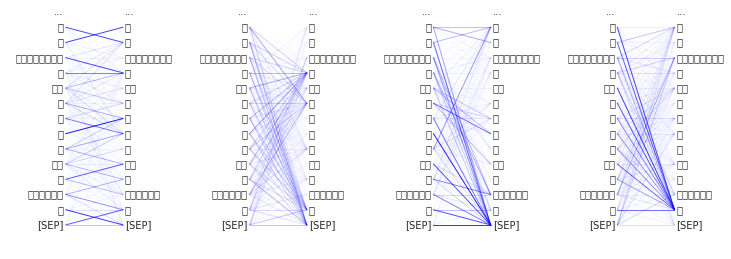

In [73]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attns"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= attn.sum(axis=-1, keepdims=True)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(12, 4))
plt.axis("off")
plot_attn(data[0], [(0, 0), (2, 0), (7, 6), (10, 5)])
plt.show()

### Avg. Attention Plots (Figure 2, Sections 3.1 and 3.2)

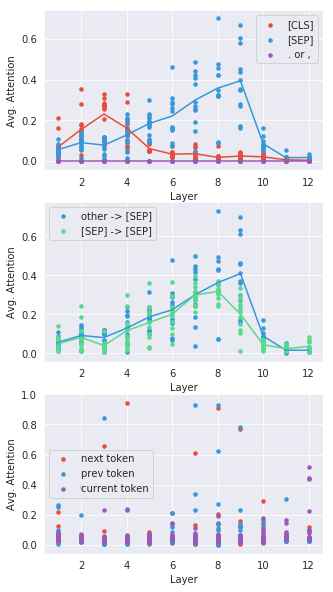

In [74]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
  add_line(key, ax, color, label, plot_avgs=False)

plt.show()

### Entropy Plots (Section 3.3, Figure 4)

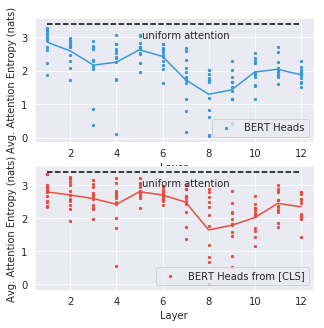

In [75]:
xs, es, avg_es = get_data_points(entropies)
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)

plt.figure(figsize=(5, 5))


def plot_entropies(ax, data, avgs, label, c):
  ax.scatter(xs, data, c=c, s=5, label=label)
  ax.plot(1 + np.arange(12), avgs, c=c)
  ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
  ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
  ax.legend(loc="lower right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BERT Heads",
               c=BLUE)
plot_entropies(plt.subplot(2, 1, 2), es_cls, avg_es_cls,
               "BERT Heads from [CLS]", c=RED)

plt.show()

### Clustering Attention Heads (Section 6, Figure 6)

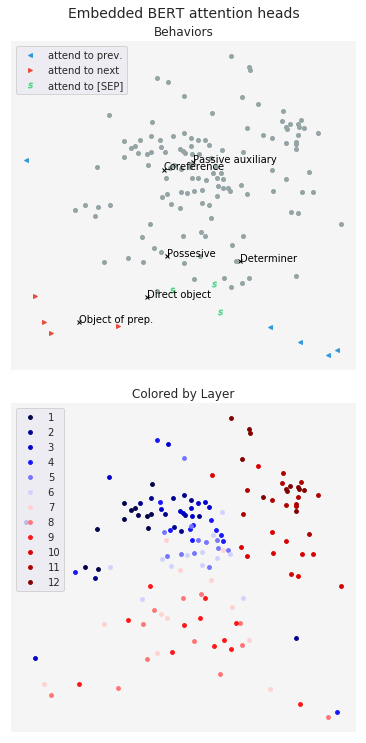

In [76]:
ENTROPY_THRESHOLD = 3.8  # When to say a head "attends broadly"
POSITION_THRESHOLD = 0.5  # When to say a head "attends to next/prev"
SPECIAL_TOKEN_THRESHOLD = 0.6  # When to say a heads attends to [CLS]/[SEP]"
# Heads that were found to have linguistic behaviors
LINGUISTIC_HEADS = {
    (4, 3): "Coreference",
    (7, 10): "Determiner",
    (7, 9): "Direct object",
    (8, 5): "Object of prep.",
    (3, 9): "Passive auxiliary",
    (6, 5): "Possesive",
}

# Use multi-dimensional scaling to compute 2-dimensional embeddings that
# reflect Jenson-Shannon divergences between attention heads.
mds = sklearn.manifold.MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                           max_iter=1000, dissimilarity="precomputed")
pts = mds.fit_transform(js_divergences)
pts = pts.reshape((12, 12, 2))
pts_flat = pts.reshape([144, 2])

colormap = cm.seismic(np.linspace(0, 1.0, 12))
plt.figure(figsize=(4.8, 9.6))
plt.title("BERT Attention Heads")

for color_by_layer in [False, True]:
  ax = plt.subplot(2, 1, int(color_by_layer) + 1)
  seen_labels = set()
  for layer in range(12):
    for head in range(12):
      label = ""
      color = GREY
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]

      if avg_attns["right"][layer, head] > POSITION_THRESHOLD:
        color = RED
        marker = ">"
        label = "attend to next"
        
      if avg_attns["left"][layer, head] > POSITION_THRESHOLD:
        color = BLUE
        label = "attend to prev."
        marker = "<"

      if entropies[layer, head] > ENTROPY_THRESHOLD:
        color = ORANGE
        label = "attend broadly"
        marker = "^"

      if avg_attns["cls"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = PURPLE
        label = "attend to [CLS]"
        marker = "$C$"
        markersize = 5

      if avg_attns["sep"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = GREEN
        marker = "$S$"
        markersize = 5
        label = "attend to [SEP]"

      if avg_attns["punct"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = SEA
        marker = "s"
        markersize = 3.2
        label = "attend to . and ,"

      if color_by_layer:
        label = str(layer + 1)
        color = colormap[layer]
        marker = "o"
        markersize = 3.8

      if not color_by_layer:
        if (layer, head) in LINGUISTIC_HEADS:
          label = ""
          color = BLACK
          marker = "x"
          ax.text(x, y, LINGUISTIC_HEADS[(layer, head)], color=color)

      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""

      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")

  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer" if color_by_layer else "Behaviors"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="best")

plt.suptitle("Embedded BERT attention heads", fontsize=14, y=1.05)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0.1, wspace=0)
plt.show()